In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


Clusters: 2, DB Index: 1.2464, Silhouette Score: 0.2903
Clusters: 3, DB Index: 1.0568, Silhouette Score: 0.3100
Clusters: 4, DB Index: 1.1558, Silhouette Score: 0.2632
Clusters: 5, DB Index: 1.1483, Silhouette Score: 0.2401
Clusters: 6, DB Index: 1.0557, Silhouette Score: 0.2696
Clusters: 7, DB Index: 1.0656, Silhouette Score: 0.2637
Clusters: 8, DB Index: 1.0003, Silhouette Score: 0.2554
Clusters: 9, DB Index: 1.0066, Silhouette Score: 0.2615
Clusters: 10, DB Index: 1.0342, Silhouette Score: 0.2646
Optimal number of clusters: 8


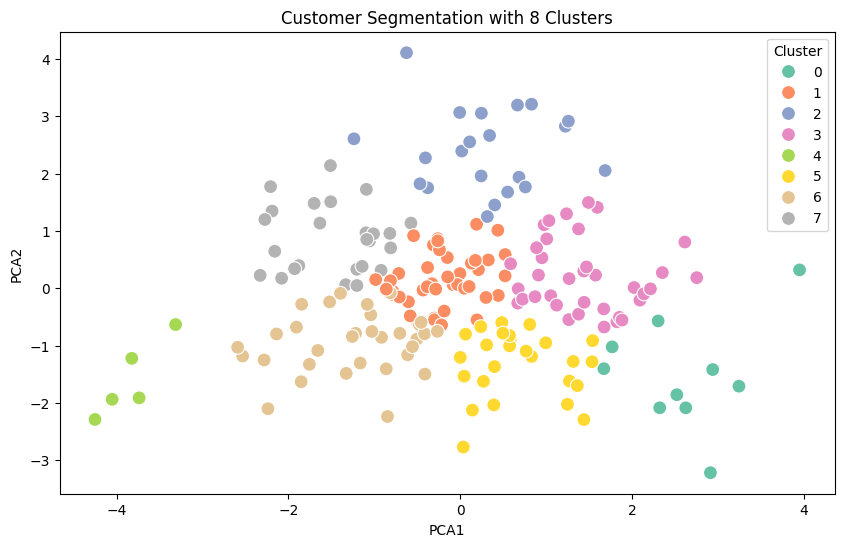

In [5]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Load data
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Step 3: Merge datasets
# Combine profile information with transaction behavior
data = transactions.merge(customers, on='CustomerID')

# Step 4: Feature engineering
# Aggregate transaction data to create customer-level features
customer_features = data.groupby('CustomerID').agg({
    'TotalValue': 'mean',  # Avg transaction value
    'TransactionID': 'count',  # Transaction frequency
    'Quantity': 'sum',  # Total quantity purchased
    'Price': 'mean',  # Avg price paid
}).reset_index()

# Add customer profile information
customer_features = customer_features.merge(customers[['CustomerID', 'Region']], on='CustomerID')

# Encode categorical features (e.g., Region)
customer_features = pd.get_dummies(customer_features, columns=['Region'])

# Normalize numerical features
scaler = StandardScaler()
numeric_cols = ['TotalValue', 'TransactionID', 'Quantity', 'Price']
customer_features[numeric_cols] = scaler.fit_transform(customer_features[numeric_cols])

# Step 5: Clustering
# Choose number of clusters (range 2-10)
db_scores = []
silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(customer_features[numeric_cols])
    
    # Compute clustering metrics
    db_index = davies_bouldin_score(customer_features[numeric_cols], cluster_labels)
    silhouette = silhouette_score(customer_features[numeric_cols], cluster_labels)
    db_scores.append((n_clusters, db_index))
    silhouette_scores.append((n_clusters, silhouette))
    
    print(f"Clusters: {n_clusters}, DB Index: {db_index:.4f}, Silhouette Score: {silhouette:.4f}")

# Select the optimal number of clusters based on DB Index
optimal_clusters = sorted(db_scores, key=lambda x: x[1])[0][0]
print(f"Optimal number of clusters: {optimal_clusters}")

# Final clustering with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(customer_features[numeric_cols])

# Step 6: Visualization
# Reduce dimensions for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(customer_features[numeric_cols])
customer_features['PCA1'] = pca_components[:, 0]
customer_features['PCA2'] = pca_components[:, 1]

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_features, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=100)
plt.title(f'Customer Segmentation with {optimal_clusters} Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

# Step 7: Report clustering results
# Save customer segmentation results to a CSV
customer_features[['CustomerID', 'Cluster']].to_csv('Customer_Segmentation.csv', index=False)


In [4]:
data

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15
...,...,...,...,...,...,...,...,...,...,...
995,T00496,C0118,P037,2024-10-24 08:30:27,1,459.86,459.86,Jacob Holt,South America,2022-01-22
996,T00759,C0059,P037,2024-06-04 02:15:24,3,1379.58,459.86,Mrs. Kimberly Wright,North America,2024-04-07
997,T00922,C0018,P037,2024-04-05 13:05:32,4,1839.44,459.86,Tyler Haynes,North America,2024-09-21
998,T00959,C0115,P037,2024-09-29 10:16:02,2,919.72,459.86,Joshua Hamilton,Asia,2024-11-11
